# Tuto fonction fastmri

## Import 

In [1]:
import sys
sys.path.append('/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/')

import fastmri
from fastmri.data import transforms as T
import h5py
import torch
import numpy as np
from matplotlib import pyplot as plt

from utils_torch import virtual_coil_reconstruction, show_coils


## Download data 

In [2]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002780.h5"
hf = h5py.File(file_path)
# print(hf)

## Manipulate data to understand and have the right format

In [3]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [7]:
# show_coils(volume_kspace, [1,2])

In [15]:
volume_kspace= torch.tensor(volume_kspace, dtype=torch.complex64)

        # plt.imshow(data[1], cmap=cmap)
dimension = len(volume_kspace.shape) -2

if dimension == 2 :
    real_kspace = torch.fft.ifft2(volume_kspace)
elif dimension == 3 : 
    real_kspace = torch.fft.fftn(volume_kspace)

real_kspace = torch.fft.fftshift(real_kspace)
print(real_kspace.shape)

/tmp/ipykernel_224231/59894742.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume_kspace= torch.tensor(volume_kspace, dtype=torch.complex64)


torch.Size([16, 16, 640, 320])


## Multicoil to Singlecoil

In [16]:
new_image_singlecoil = virtual_coil_reconstruction(real_kspace)
print(new_image_singlecoil.shape)

/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs = torch.tensor(imgs, dtype=torch.complex64)
/home/lo276838/Modèles/mri-dl-recon/src/mri_dlrecon/functions_torch/utils_torch.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phase_reference = torch.tensor(


torch.Size([16, 640, 320])


## Test for undersampling Mask 

### Original image

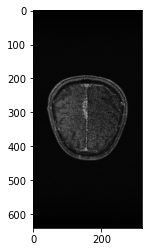

In [17]:
image_goodShape = new_image_singlecoil[0]
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')

In [ ]:
new

NameError: name 'new' is not defined

### Fastmri

Choose the sampling mask you want between the following.

random : genere a sampling mask randomly  
equispaced : genere a sampling mask with qually-spaced k-space lines  
equispaced_fraction : similar to equispaced with more precision about acceleration rate  
magic : genere a sampling mask who exploit conjugate symmetry  
magic_fraction : similar to magic with more precision about acceleration rate  

In [ ]:
from fastmri.data.subsample import create_mask_for_mask_type

mask_type_str = "random"
center_fractions = [0.08, 0.04]
accelerations = [4, 8]

mask_func = create_mask_for_mask_type(mask_type_str, center_fractions, accelerations)

masked_func represent here the binary data of the mask.   
0 mean informatiosn in the data are note conserve.   
1 mean you take the information.   
    
accelerated_data is the fusion between the original data and sampling data.   
This is the data we gonna use.

In [ ]:
masked_data , _ = mask_func(new_image_singlecoil.shape) 
# print(masked_data)

accelerated_data = new_image_singlecoil * masked_data
# print(accelerated_data)
print(accelerated_data.shape)

torch.Size([16, 640, 320])


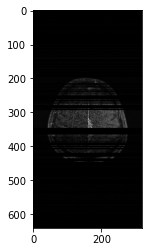

In [ ]:
image_goodShape0 = accelerated_data[0]
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')

### Fasmri Reproductible Benchmark

In [ ]:

# def gen_mask(kspace, accel_factor=8, seed=None):
#     # inspired by https://github.com/facebookresearch/fastMRI/blob/master/common/subsample.py
#     shape = kspace.shape
#     num_cols = shape[-1]
#     center_fraction = (32 // accel_factor) / 100
#     acceleration = accel_factor

#     # Create the mask
#     num_low_freqs = int(round(num_cols * center_fraction))
#     prob = (num_cols / acceleration - num_low_freqs) / (num_cols - num_low_freqs)
#     mask = np.random.default_rng(seed).uniform(size=num_cols) < prob
#     pad = (num_cols - num_low_freqs + 1) // 2
#     mask[pad:pad + num_low_freqs] = True

#     # Reshape the mask
#     mask_shape = [1 for _ in shape]
#     mask_shape[-1] = num_cols
#     mask = mask.reshape(*mask_shape)
#     return mask

# def gen_mask(kspace, accel_factor=8):
#     shape = kspace.shape
#     num_cols = shape[-1]

#     center_fraction = (32 // accel_factor) / 100
#     acceleration = accel_factor

#     # Create the mask
#     num_low_freqs = int(round(num_cols * center_fraction))
#     prob = (num_cols / acceleration - num_low_freqs) / (num_cols - 3 * num_low_freqs)
#     num_sampling = int(prob * num_cols)
#     # selected_indexes = np.random.default_rng().randint(0, num_cols, size=(num_sampling, 2)).mean(axis=-1).astype('int')
#     selected_indexes = np.random.default_rng().choice(num_cols, size=num_sampling, replace=False)
#     mask = np.zeros((num_cols,)).astype('bool')
#     mask[selected_indexes] = True
#     pad = (num_cols - num_low_freqs + 1) // 2
#     mask[pad:pad + num_low_freqs] = True

#     # Reshape the mask
#     mask_shape = [1 for _ in shape]
#     mask_shape[-1] = num_cols
#     mask = mask.reshape(*mask_shape)
#     return mask

import tensorflow as tf

def gen_mask(kspace, accel_factor = 8, multicoil=False, fixed_masks=False):
    shape = tf.shape(kspace)
    num_cols = shape[-1] # initialement -1
    center_fraction = (32 // accel_factor) / 100
    num_low_freqs = tf.dtypes.cast(num_cols, 'float32') * center_fraction
    num_low_freqs = tf.dtypes.cast((tf.round(num_low_freqs)), 'int32')
    prob = (num_cols / accel_factor - tf.dtypes.cast(num_low_freqs, 'float64')) / tf.dtypes.cast((num_cols - num_low_freqs), 'float64')
    if fixed_masks:
        tf.random.set_seed(0)
        seed = 0
    else:
        seed = None
    mask = tf.random.uniform(shape=tf.expand_dims(num_cols, axis=0), dtype='float64', seed=seed) < prob
    pad = (num_cols - num_low_freqs + 1) // 2
    final_mask = tf.concat([
        mask[:pad],
        tf.ones([num_low_freqs], dtype=tf.bool),
        mask[pad+num_low_freqs:],
    ], axis=0)

    # # Reshape the mask
    mask_shape = tf.ones_like(shape)
    if multicoil:
        mask_shape = mask_shape[:3]
    else:
        mask_shape = mask_shape[:2]
    final_mask_shape = tf.concat([
        mask_shape,
        tf.expand_dims(num_cols, axis=0),
    ], axis=0)
    final_mask_reshaped = tf.reshape(final_mask, final_mask_shape)
    # we need the batch dimension for cases where we split the batch accross
    # multiple GPUs
    if multicoil:
        final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1, 1])
    else:
        final_mask_reshaped = tf.tile(final_mask_reshaped, [shape[0], 1, 1])
    fourier_mask = tf.cast(final_mask_reshaped, tf.uint8)
    return fourier_mask


2023-12-20 13:39:49.181211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 13:39:49.181262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 13:39:49.182892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 13:39:49.190962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 13:39:52.262735: W tensorflow/compiler/tf2

In [ ]:
#  Representation binaire qui indique quel point sera conservé. 

masked_data1 = gen_mask(new_image_singlecoil)
# print(masked_data1)

accelerated_data1 = new_image_singlecoil * masked_data1
# print(accelerated_data)
print(accelerated_data1.shape)

2023-12-20 13:39:55.577065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 334 MB memory:  -> device: 0, name: Quadro M4000, pci bus id: 0000:03:00.0, compute capability: 5.2


(16, 640, 320)


/home/lo276838/.local/lib/python3.10/site-packages/tensorflow/python/framework/constant_op.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


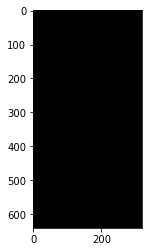

In [ ]:
image_goodShape1 = accelerated_data1[0]
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')

## Result 

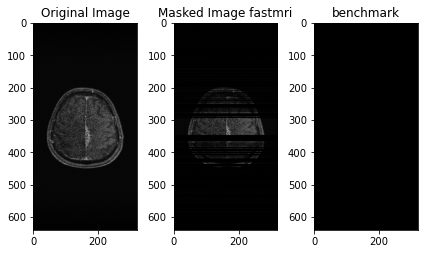

In [ ]:

plt.subplot(1, 3, 1)
plt.imshow(np.abs(image_goodShape.numpy()), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(image_goodShape0.numpy()), cmap='gray')
plt.title('Masked Image fastmri')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(image_goodShape1.numpy()), cmap='gray')
plt.title('benchmark')

plt.tight_layout()
plt.show()
